In [1]:
import os
import math
import dill
from itertools import combinations

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
import statsmodels as sm

import suite2p as s2p

import TwoPUtils
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
# ko_mice = [m for m in ko_mice if m not in ['Cre8']]
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice

plt.rcParams['pdf.fonttype']=42



%matplotlib inline

%load_ext autoreload
%autoreload 2

1) get licks within previous reward zone as a function of trials
    
    a) binarize where > 1 lick in the old anticipatory zone is set to 1 and 0 otherwise

2) using statsmodels fit mixed linear effects model with a binomial link function
    
    a) test for a significant effect of the group 
    
3) for every 10 trials post reward, calculated average lick rate in anticipatory zone
    
    a) rank sums test to compare groups with bonferonni correction
    
    

In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/reward_reversal"
os.makedirs(figdir, exist_ok = True)

In [7]:
def get_early_licks(sess):
    
    # for t, (start,stop) in enumerate(zip(sess.trial_start_inds,sess.teleport_inds)):
    #     pos = sess.timeseries['t'][0,start:stop]
    #     licks = sess.timeseries['nonconsum_licks'
    
    t_early_bins = sess.trial_matrices['bin_edges'][1:]
    rzone_early = (t_early_bins>=sess.rzone_early['tfront']-5)*(t_early_bins<=sess.rzone_early['tfront'])
    baseline_mask = (sess.trial_info['sess_num']==6)*(sess.trial_info['LR']==-1)*(sess.trial_info['block_number']<2)
    ret_mask = (sess.trial_info['sess_num']==8)*(sess.trial_info['block_number']>1)
    rev_mask = (~baseline_mask)*(sess.trial_info['LR']==-1)*(~ret_mask)
    
    lr_early = sess.trial_matrices['licks_sum'][:, rzone_early].sum(axis=1)
    lr_rev = lr_early[rev_mask]
    sess_num = sess.trial_info['sess_num'][rev_mask]
    return lr_rev, sess_num
    

In [4]:
mouse = ctrl_mice[0]
sess = u.single_mouse_concat_vr_sessions(mouse, date_inds=[6, 7])
lr = get_early_licks(sess)

In [5]:
sess.trial_info.keys()

dict_keys(['LR', 'block_number', 'sess_num_ravel', 'sess_num'])

In [25]:
df = []
for m, mouse in enumerate(ctrl_mice):
    sess = u.single_mouse_concat_vr_sessions(mouse, date_inds=[6, 7])
    lr, sess_num = get_early_licks(sess)
    _df = pd.DataFrame(columns=['mouse', 'cond', 'm', 'lr', 'lr_bin', 'trial', 'max_trial', 'sess_num'], index = range(lr.shape[0]) )
    _df['mouse'] = mouse
    _df['cond'] = 'ctrl'
    _df['m'] = m
    _df['lr'] = lr
    _df['lr_bin'] = 1*(lr>1)
    _df['trial'] = np.arange(lr.shape[0])
    _df['max_trial'] = lr.shape[0]
    _df['sess_num']=sess_num
    df.append(_df)
    
for m, mouse in enumerate(ko_mice[:-1]):
    sess = u.single_mouse_concat_vr_sessions(mouse, date_inds=[6, 7])
    lr, sess_num = get_early_licks(sess)
    _df = pd.DataFrame(columns=['mouse', 'cond', 'm', 'lr', 'lr_bin', 'trial', 'sess_num'], index = range(lr.shape[0]) )
    _df['mouse'] = mouse
    _df['cond'] = 'cre'
    _df['m'] = m
    _df['lr'] = lr
    _df['lr_bin'] = 1*(lr>1)
    _df['trial'] = np.arange(lr.shape[0])
    _df['max_trial']=lr.shape[0]
    _df['sess_num']=sess_num
    df.append(_df)

df = pd.concat(df, ignore_index=True)



In [26]:
print(np.amin(df['max_trial'].to_numpy()), np.amax(df['max_trial'].to_numpy()))

60 130


In [67]:
# import statsmodels.genmod
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM as BBMGLM

# try:
#     model = BBMGLM.from_formula('lr_bin ~  trial*C(cond)', {'int': '0+C(mouse)', 'sl': '0 + C(mouse)*trial'}, df[df['trial']<=100])
# except RuntimeWarning:
#     print("didn't converge")
model = BBMGLM.from_formula('lr_bin ~  trial*C(cond) + C(cond)*C(sess_num)', {'int': '0+C(mouse)'}, df[df['trial']<=80])
result = model.fit_vb()

In [14]:
import numpy as np
print(np.angle(np.exp(1j*np.pi*3/2)))
print(np.pi/2)


-1.5707963267948968
1.5707963267948966


In [68]:
result.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,2.0691,0.0801,,,
C(cond)[T.ctrl],M,2.9652,0.1082,,,
C(sess_num)[T.7.0],M,0.4741,0.1156,,,
C(cond)[T.ctrl]:C(sess_num)[T.7.0],M,0.0537,0.1516,,,
trial,M,-0.0785,0.0017,,,
trial:C(cond)[T.ctrl],M,-0.0206,0.0020,,,
int,V,0.1731,0.1786,1.189,0.832,1.699


In [29]:
p_lick = result.predict()
lb = df[df['trial']<=80]['lr_bin'].to_numpy()
print(p_lick.shape)

log_loss = (lb*np.log(p_lick) + (1-lb)*np.log(1-p_lick)).sum()
print(log_loss)

(1173,)
-578.2001270083699


In [13]:
summ = result.summary()
summ
# summ.tables[0]['Post. Mean']['Intercept']


,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,2.0736,0.0800,,,
C(cond)[T.ctrl],M,2.9412,0.1081,,,
C(sess_num)[T.7.0],M,0.5019,0.1155,,,
trial,M,-0.0791,0.0017,,,
trial:C(cond)[T.ctrl],M,-0.0194,0.0020,,,
int,V,0.1716,0.1786,1.187,0.831,1.697


In [14]:
summ.tables[0]['Post. Mean'].keys()

Index(['Intercept', 'C(cond)[T.ctrl]', 'C(sess_num)[T.7.0]', 'trial',
       'trial:C(cond)[T.ctrl]', 'int'],
      dtype='object')

In [15]:
import joblib
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM as BBMGLM

In [69]:
def make_df(mouse, cond):
    lr, sess_num = get_early_licks(u.single_mouse_concat_vr_sessions(mouse, date_inds=[6, 7]))
    df = pd.DataFrame(columns=['mouse', 'cond', 'm', 'lr', 'lr_bin', 'trial', 'max_trial', 'sess_num'], index = range(lr.shape[0]) )
    df['mouse'] = mouse
    df['cond'] = cond
    df['lr'] = lr
    df['lr_bin'] = 1*(lr>1)
    df['trial'] = np.arange(lr.shape[0])
    df['max_trial'] = lr.shape[0]
    df['sess_num']=sess_num
    return df
            
def concat_df(ctrl_inds):
    df = []
    for k in range(len(ctrl_mice)+len(ko_mice)):
        if k in ctrl_inds:
            df.append(make_df(all_mice[k], 'ctrl'))
        else:
            df.append(make_df(all_mice[k], 'cre'))
    df = pd.concat(df)
    return df

def fit_model(df, i):
    
    # model = BBMGLM.from_formula('lr_bin ~  trial*C(cond)', {'int': '0+C(mouse)', 'sl': '0 + C(mouse)*trial'}, df[df['trial']<=90])
    model = BBMGLM.from_formula('lr_bin ~  trial*C(cond) + C(cond)*C(sess_num)', {'int': '0+C(mouse)'}, df[df['trial']<=80])
    result = model.fit_vb()

    p_lick = result.predict()
    lb = df[df['trial']<=80]['lr_bin'].to_numpy()


    logloss = (lb*np.log(p_lick) + (1-lb)*np.log(1-p_lick)).sum()

    summ = result.summary()
    cond_beta = summ.tables[0]['Post. Mean']['C(cond)[T.ctrl]']
    cond_trial_intxn = summ.tables[0]['Post. Mean']['trial:C(cond)[T.ctrl]']
    
    if i%10==0:
        print(i)
    return [logloss, cond_beta, cond_trial_intxn]

def run_model(ctrl_inds,i):
    return fit_model(concat_df(ctrl_inds),i)

# df 
all_mice = ctrl_mice +ko_mice
# [None for i, ctrl_inds in enumerate(combinations(range(len(all_mice)), len(ctrl_mice)))]
# shuff_results  = []
# for i, ctrl_inds in enumerate(combinations(range(len(all_mice)), len(ctrl_mice))):
#     if i<1000:
#         shuff_results.append(run_model(ctrl_inds,i))
# # shuff_results = [run_model(ctrl_inds,i) for i, ctrl_inds in enumerate(combinations(range(len(all_mice)), len(ctrl_mice)))]
shuff_results = joblib.Parallel(n_jobs=-1)(joblib.delayed(run_model)(ctrl_inds,i) for i, ctrl_inds in enumerate(combinations(range(len(all_mice)), len(ctrl_mice))))    


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np

In [70]:
shuff_results = np.array(shuff_results)
np.save('./reversal_shuff_results.npy', shuff_results)

In [71]:
shuff_results = np.load('./reversal_shuff_results.npy')

-717.1342392431044 -526.8320213938488
0.0018356643356642888


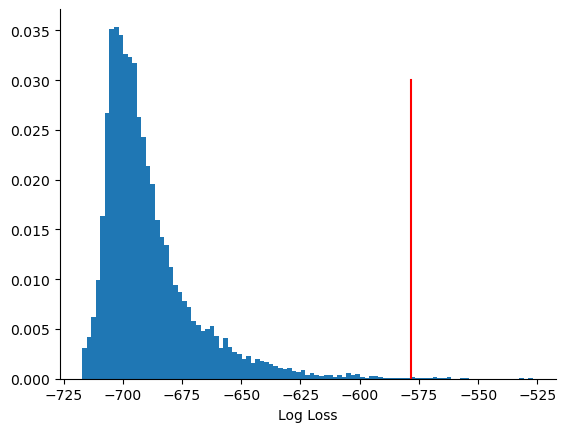

In [80]:
log_loss
fig, ax = plt.subplots()
bin_edges = np.linspace(np.percentile(shuff_results[:,0],1), np.percentile(shuff_results[:,0],100), num=100)
print(bin_edges[0], bin_edges[-1])

ax.hist(shuff_results[:,0], bin_edges, density=True)
ax.plot([log_loss, log_loss], [0, .03], color='red')
print(1- (log_loss>shuff_results[:, 0]).sum()/shuff_results.shape[0])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Log Loss')

fig.savefig(os.path.join(figdir, "log_loss_histogram.pdf"))

In [73]:
a = np.zeros((3,))<1
a[0] = False

b = np.zeros((3,))<1

print((a&b).sum()/(a|b).sum())

0.6666666666666666


In [74]:
result.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,2.0691,0.0801,,,
C(cond)[T.ctrl],M,2.9652,0.1082,,,
C(sess_num)[T.7.0],M,0.4741,0.1156,,,
C(cond)[T.ctrl]:C(sess_num)[T.7.0],M,0.0537,0.1516,,,
trial,M,-0.0785,0.0017,,,
trial:C(cond)[T.ctrl],M,-0.0206,0.0020,,,
int,V,0.1731,0.1786,1.189,0.832,1.699


0.0076048951048951485


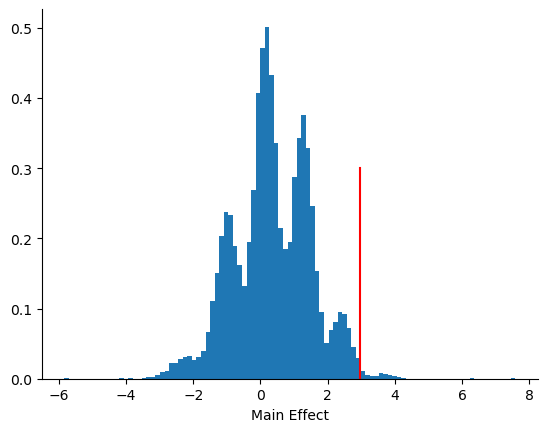

In [81]:
fig, ax =plt.subplots()
bins = np.linspace(np.amin(shuff_results[:,1]), np.amax(shuff_results[:,1]), num=100)
_= ax.hist(shuff_results[:,1],bins, density=True)
ax.plot(summ.tables[0]['Post. Mean']['C(cond)[T.ctrl]']*np.ones((2,)), [0, .3], color='red')
summ = result.summary()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print(1-(summ.tables[0]['Post. Mean']['C(cond)[T.ctrl]']>shuff_results[:,1]).sum()/shuff_results.shape[0])
ax.set_xlabel('Main Effect')

fig.savefig(os.path.join(figdir, "intercept_hist.pdf"))

0.7513111888111887


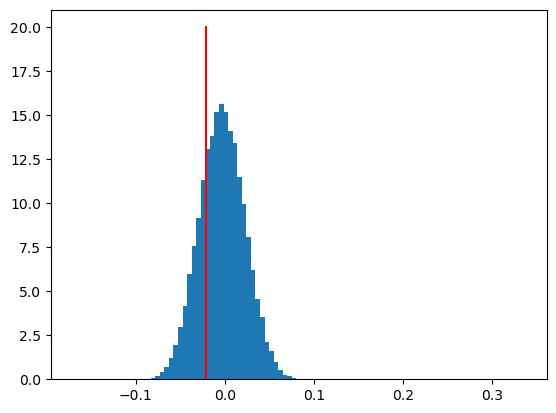

In [82]:
fig, ax =plt.subplots()
bins = np.linspace(np.amin(shuff_results[:,2]), np.amax(shuff_results[:,2]), num=100)
_= ax.hist(shuff_results[:,2],bins,density=True)
ax.plot(summ.tables[0]['Post. Mean']['trial:C(cond)[T.ctrl]']*np.ones((2,)), [0, 20], color='red')
summ = result.summary()
print(1-(summ.tables[0]['Post. Mean']['trial:C(cond)[T.ctrl]']>shuff_results[:,2]).sum()/shuff_results.shape[0])


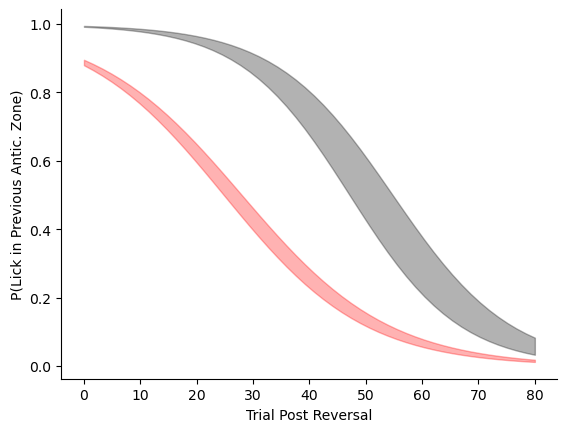

In [83]:
fig, ax = plt.subplots()
x = np.linspace(0,80)

intcpt = summ.tables[0]['Post. Mean']['Intercept']
cond_fe = summ.tables[0]['Post. Mean']['C(cond)[T.ctrl]']
trial_fe = summ.tables[0]['Post. Mean']['trial']
trial_cond_fe = summ.tables[0]['Post. Mean']['trial:C(cond)[T.ctrl]']

intcpt_se = summ.tables[0]['Post. SD']['Intercept']
cond_fe_se = summ.tables[0]['Post. SD']['C(cond)[T.ctrl]']
trial_fe_se = summ.tables[0]['Post. SD']['trial']
trial_cond_fe_se = summ.tables[0]['Post. SD']['trial:C(cond)[T.ctrl]']

q = 1/(1+np.exp(-(intcpt + cond_fe + trial_fe*x + trial_cond_fe*x )))
# ax.plot(x,q, color='black')
q_min = 1/(1+np.exp(-((intcpt-intcpt_se) + cond_fe - cond_fe_se + (trial_fe-trial_fe_se)*x + (trial_cond_fe-trial_cond_fe_se)*x )))
# ax.plot(x,q_min, color='black')
q_max = 1/(1+np.exp(-((intcpt+intcpt_se) + cond_fe + cond_fe_se + (trial_fe+trial_fe_se)*x + (trial_cond_fe+trial_cond_fe_se)*x )))
ax.fill_between(x,q_min, q_max, color='black', alpha=.3)


# q = 1/(1+np.exp(-(intcpt + trial_fe*x )))
q_min = 1/(1+np.exp(-((intcpt-intcpt_se) + (trial_fe-trial_fe_se)*x  )))
q_max = 1/(1+np.exp(-((intcpt+intcpt_se) + (trial_fe+trial_fe_se)*x  )))
ax.fill_between(x,q_min, q_max, color='red', alpha=.3)

# ax.plot(x,q, color='red')

ax.set_xlabel('Trial Post Reversal')
ax.set_ylabel('P(Lick in Previous Antic. Zone)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir, "mixed_model_fits.pdf"))

In [84]:
df.head()

,mouse,cond,m,lr,lr_bin,trial,max_trial,sess_num
0,4467331.1,ctrl,0,7.0,1,0,130,6.0
1,4467331.1,ctrl,0,9.0,1,1,130,6.0
2,4467331.1,ctrl,0,11.0,1,2,130,6.0
3,4467331.1,ctrl,0,10.0,1,3,130,6.0
4,4467331.1,ctrl,0,6.0,1,4,130,6.0


(-0.1, 1.1)

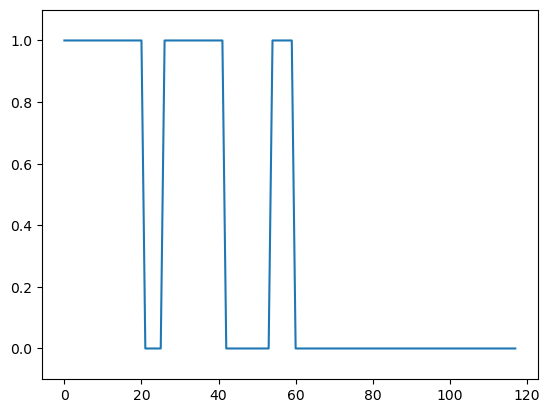

410
570
770
790
810
870
930
1140
1160
1220
1260
1300
1340
1360
1600
2410
2430
2770
2790
2830
2850
2870
2890
3120
3550
3570
3690
3910
3930
4510
4980
5590
6020
6060
6160
6180
6350
6370
6940
7020
7060
7080
7330
7350
7680
8110
8320
8340
8360
8400
8620
8990
9030
9650
9780
9840
9900
10560
10600
10740
10820


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")

240
320
380
420
490
510
700
760
1410
1450
1510
1840
2040
2330
2350
2740
2970
3240
3300
3900
4350
4370
4410
4430
4790
4810
4830
4850
4870
4930
5020
5390
5450
5510
5780
5860
5960
5980
6290
6560
6620
6660
6680
6720
6740
7480
7560
7790
7980
8000
8020
8100
8330
8560
8580
8680
8700
8720
8910
9300
9320
9340
9570
9860
9880
10040
10060
10730
10800
11080
11100


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/l

0
20
110
150
600
620
740
1030
1390
1470
1490
1530
2070
2090
2110
2480
2580
2640
2700
2720
2780
3030
3510
3530
3590
3670
4130
4500
5010
5650
5930
7010
7400
7420
7690
7730
7750
7830
7850
7870
8270
8710
8900
8920
9250
10050
10170
10380
10400
10610
10980
11230


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaf

30
180
630
750
1060
1730
2000
2170
2270
2860
3230
3680
4340
4360
4380
4590
4670
4880
5500
5880
6030
6130
6400
6580
7260
7280
7360
7520
7540
7580
8260
8550
8960
8980
9000
9580
9620
9660
9800
9820
9990
10010
10200
10220
10530
10550
10570
10590
11240


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s*

270
350
370
450
470
670
1050
1070
1350
1370
1870
2370
2670
2690
2760
2840
3080
3100
3200
3310
3370
3500
3790
4030
4050
4330
4520
4630
4650
4900
4920
4940
5030
5050
5540
5710
5750
6000
6520
6540
6670
6690
6930
6950
6970
7190
7710
8290
8590
8780
8930
8950
8970
9270
9290
9420
9550
9770
10240
10260
10390
10430
10920
11130
11150
11170
11190
11210


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mp

430
1090
1240
1280
1320
1380
1400
1420
1540
1620
1740
1920
1940
1960
1980
2060
2280
2650
3520
3560
3750
3770
4020
4140
4180
4660
4680
4700
4720
4740
4760
5210
5310
5330
5430
6050
6090
6110
6150
6780
6800
7130
7250
7270
7290
7460
7500
7890
7910
7930
7970
7990
8380
8480
8790
8850
9100
9330
9350
9370
9430
9600
9640
9970
10100
10450
10870
10910
11060
11180
11200
11300
11320


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))


70
170
1270
1520
1950
1970
2500
2730
3290
3710
3760
3960
4210
4250
4290
4890
5350
5410
6300
6510
6530
6550
6710
6810
6920
7050
7300
7340
7440
8220
8240
9400
9440
9460
9480
9500
9520
9560
9790
9890
9910
10280
11000
11250
11270
11290
11340
11360
11380
11400


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mp

60
100
120
140
190
690
820
1180
1310
1440
1460
1570
1660
1700
1720
1820
1860
2030
2050
2290
2310
2520
3410
3430
3880
4270
4690
4710
4820
5180
5640
5660
5730
6260
6770
6790
7030
7220
7240
7370
7390
7410
7450
7600
7770
7900
7920
8160
8250
8350
8520
8540
8690
8820
8860
9010
9140
9830
9920
10190
10290
10310
10420
10630
11160
11310
11370
160
200
220
260
300
340
560
580
830
850
890
910
990
1670
1990
2010
2210
2230
2440
2460
2820
3990
4010
4400
4420
4440
4460
5460
5740
6230
6250
6310
6390
6990
7470
7490
7590
8190
8670
8770
8810
9130
9150
9850
9870
10080
10300
10440
10940
10960
11050
11070
11090
11280


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s

40
80
280
640
940
1200
1290
1480
1500
1890
1910
1930
2190
2620
2680
2940
2960
3600
3640
3810
3830
3940
3980
4000
4450
4490
4600
4620
5900
6420
6960
7150
7210
7570
7670
8010
8030
8470
8600
8640
9050
9980
10210
10470
11430


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + n

10
290
310
390
500
520
650
780
800
950
970
1080
1120
1250
1760
2300
2320
2340
2360
2450
2610
2800
3060
3340
3660
3720
3850
3870
3890
4390
4580
4750
4950
5290
5610
5760
5870
5910
6100
6170
6190
6210
6320
6700
6830
6850
6870
6980
7000
7040
7800
8180
8200
8880
9070
9390
9610
9630
9730
10030
10150
10460
10520
10540
10710
11020
11040
11410


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))


960
980
1000
1680
1780
1800
2250
2420
2530
2600
2880
3070
3160
3180
3250
3270
3320
3450
3730
3840
3860
3950
4470
4770
5190
5280
5360
5560
5580
5670
5770
5800
6010
6640
6730
6750
6900
7070
7310
7610
7630
7720
7740
7950
8080
8310
8370
8740
8760
8800
8890
9190
9210
9360
9380
9590
9930
9950
10130
10680
10700
10720
10850
11110
210
230
250
360
400
480
540
1430
2080
2120
2140
2260
2630
2900
3360
3380
3540
4090
4110
4150
4230
4800
5070
5520
5920
6040
6270
6410
6590
6610
7620
7700
8050
8070
8090
8500
8870
9060
9530
9700
9760
10000
10020
10750
10790
10810
11140
11390


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")

660
880
1150
1170
1330
1690
1710
1810
2200
2220
2550
2570
2660
2910
2930
2950
2990
3010
3050
3400
3420
3440
3460
3480
3580
3620
4530
4840
4860
5130
5150
5170
5230
5250
5270
5940
6330
6430
6630
6760
7170
7380
7650
8280
8300
8420
8440
8460
9180
9540
10320
10340
10510
11030
11330
11350


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) *

330
530
550
590
680
900
1010
1100
1190
1210
1880
1900
2390
2590
3140
3190
3280
3700
4080
4170
4260
4480
4550
4640
4780
4910
5090
5110
5420
5440
5530
5550
5600
5840
6070
6200
6470
6490
6820
7090
7230
7810
8530
8730
8840
9090
9110
9450
9740
9810
10120
10180
10330
10480
10580
10670
10690
10770
10880
10900
11120


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s

1230
1550
2160
2180
2470
2490
2510
2710
3220
3260
3390
4240
5040
5060
5100
5240
5260
5300
5320
5570
5630
5690
5950
6080
6120
6140
6220
6450
7100
7120
7140
7160
7180
7200
7760
7780
8570
9170
9230
9410
9940
9960
10500
10830
10990
11010
840
1110
1130
1590
1610
1630
1750
1770
2100
2540
2560
2810
3040
3490
3740
3800
3820
4100
4120
4540
4560
5000
5080
5120
5140
5160
5480
5620
5890
6440
6600
6910
7510
7530
7550
8040
8060
8430
8490
8510
8660
8750
8940
9160
9200
9310
9470
9490
9510
9680
9720
10070
10230
10250
10270
10620
10640
10930
10950
10970
11220
11260


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not co

50
90
130
720
860
1650
1790
2020
3090
3970
4220
4570
4610
4970
4990
5220
5370
5680
5700
5720
5850
6570
7320
8120
8140
9020
9220
9240
9260
9280
9670
9690
9710
10090
10110
10360
10650


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) *

610
920
1560
1580
1640
2240
3110
3130
3150
3170
3210
3610
3630
3650
3920
4040
4060
4160
4200
4280
4300
4320
4730
5380
5400
5790
5810
5830
5970
5990
6240
6340
6360
6650
6840
6860
6880
7110
7430
7640
7660
8130
8150
8170
8210
8230
8390
8410
8450
8830
9040
9080
9120
9750
10350
10370
10490
10890
440
460
710
730
1020
1040
1830
1850
2130
2150
2380
2400
2750
2920
2980
3000
3020
3330
3350
3470
3780
4070
4190
4310
4960
5200
5340
5470
5490
5820
6280
6380
6460
6480
6500
6890
7820
7840
7860
7880
7940
7960
8610
8630
8650
10140
10160
10410
10660
10760
10780
10840
10860
11420


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")
/home/mplitt/mambaforge/envs/STX3/l

In [85]:
mask = df['mouse']==ctrl_mice[8]
_df = df.loc[mask]

fig, ax = plt.subplots()
ax.plot(_df['trial'],sp.ndimage.gaussian_filter1d(_df['lr_bin'],.5))
ax.set_ylim(-.1,1.1)

In [ ]:

# calculate log loss

# compare to log loss of model that just has an intercept and trial

In [ ]:
# run permutation test

# for each possible permutation of mice across conditions

# fit model

# return log loss and trial x condition beta value


